### 导入autoload扩展

In [3]:
%load_ext autoreload
%autoreload 2

### 下载并载入[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)数据集

In [46]:
from utils import download_minist
from full_connect_network import FullConnectNet
from solve import Solver
import random

data = download_minist()

hidden_dims = [128, 64, 32]
activation = ['relu']
reg = 1e-3
loss = 'ce'

three_layer_model = FullConnectNet(
    hidden_dims=hidden_dims, 
    types=activation, 
    reg=reg, 
    loss=loss
)

three_layer_net = Solver(
    model=three_layer_model, 
    data=data,
    update_rule='sgd_momentum',
    optim_config = {
        'learning_rate': 1e-2
    },
    lr_decay=0.8,
    batch_size=64,
    print_iter=100
)

three_layer_net.train() 

#####################################################################
###                      best params                              ###
#####################################################################

# {
#     hidden_dims = [128, 64, 32]
#     activation = ['relu']
#     reg = 1e-3
#     loss = 'ce'
#     three_layer_model = FullConnectNet(
#         hidden_dims=hidden_dims, 
#         types=activation, 
#         reg=reg, 
#         loss=loss
#     )
#     three_layer_net = Solver(
#         model=three_layer_model, 
#         data=data,
#         update_rule='sgd_momentum',
#         optim_config = {
#             'learning_rate': 1e-2
#         },
#         lr_decay=0.9 / 0.8,
#         batch_size=64,
#         print_iter=100
#     )
# }



(Time   0.00 s; Iteration    1 / 9370) loss 10.255659
[Epoch  0 / 10] train accuracy: 0.116567; val accuracy: 0.117000
(Time   1.15 s; Iteration  101 / 9370) loss 0.882058
(Time   1.86 s; Iteration  201 / 9370) loss 0.665308
(Time   2.40 s; Iteration  301 / 9370) loss 0.705039
(Time   2.92 s; Iteration  401 / 9370) loss 0.643462
(Time   3.45 s; Iteration  501 / 9370) loss 0.718781
(Time   3.97 s; Iteration  601 / 9370) loss 0.681302
(Time   4.48 s; Iteration  701 / 9370) loss 0.574897
(Time   4.98 s; Iteration  801 / 9370) loss 0.469229
(Time   5.47 s; Iteration  901 / 9370) loss 0.464941
[Epoch  1 / 10] train accuracy: 0.844217; val accuracy: 0.836400
(Time   6.52 s; Iteration 1001 / 9370) loss 0.411876
(Time   7.02 s; Iteration 1101 / 9370) loss 0.641408
(Time   7.52 s; Iteration 1201 / 9370) loss 0.486772
(Time   8.02 s; Iteration 1301 / 9370) loss 0.571771
(Time   8.51 s; Iteration 1401 / 9370) loss 0.427978
(Time   9.01 s; Iteration 1501 / 9370) loss 0.424184
(Time   9.51 s; Itera

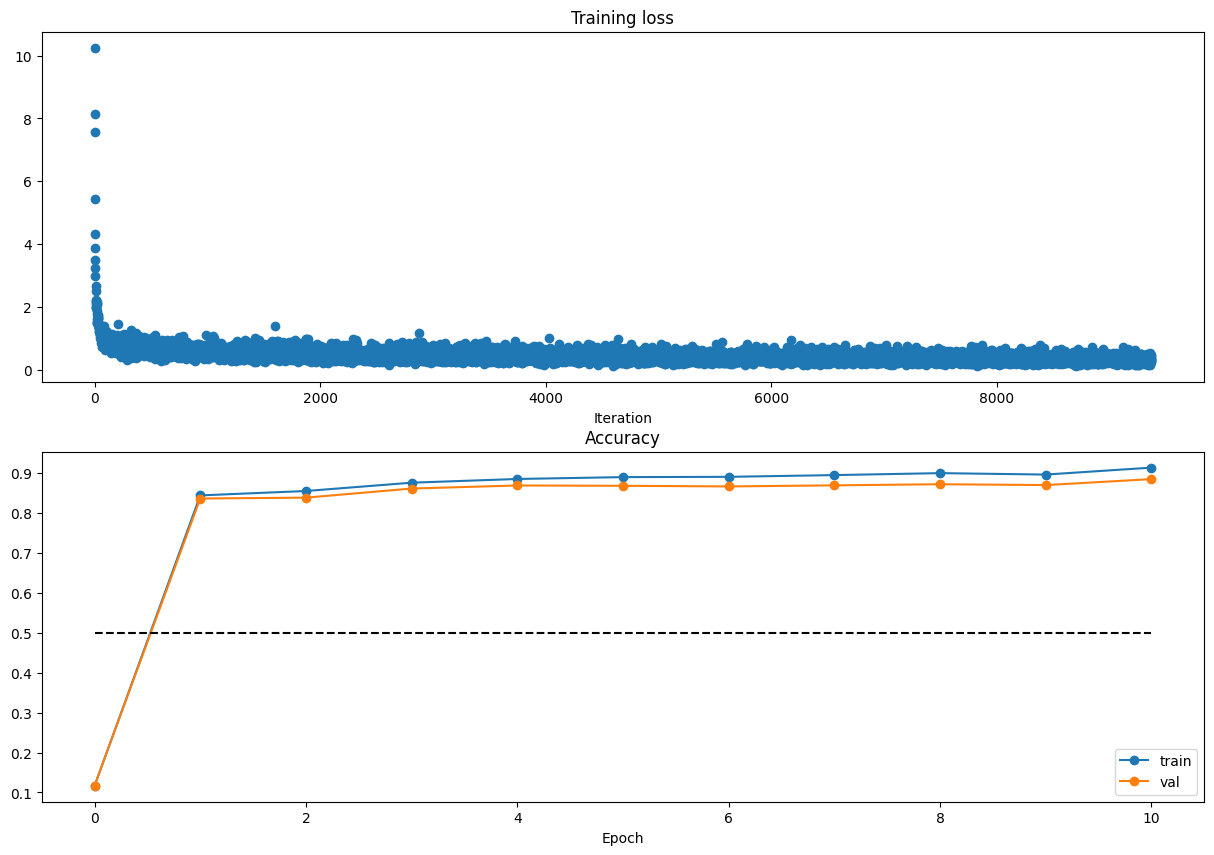

In [47]:
import matplotlib.pyplot as plt

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(three_layer_net.loss_hist, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(three_layer_net.train_acc_hist, '-o', label='train')
plt.plot(three_layer_net.val_acc_hist, '-o', label='val')
plt.plot([0.5] * len(three_layer_net.val_acc_hist), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 10)
plt.show()